#Amazon sentiment Analysis
The analysis focuses on determining or predicitng wherether a sentiment is negative or positive using Natural Language Processing (NLP) algorithms

## Check for mismatchlibraries dependecies for the analysis

In [1]:
%pip check

No broken requirements found.
Note: you may need to restart the kernel to use updated packages.


## Import the neccessary Libraries

In [3]:
import os
import numpy as np

import matplotlib.pyplot as plt
import re
from pickle import dump
from pickle import load

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
# Set the NLTK data directory
nltk_data_dir = './data/raw'
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)

# Download the required NLTK resources to the specified directory
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)
import tensorflow as tf

# from  .keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, TimeDistributed
# from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


[nltk_data] Downloading package stopwords to ./data/raw...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./data/raw...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to ./data/raw...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
# Path and regex
path = "./data/domain_sentiment_data/sorted_data_acl/"
regex_review = re.compile("<review_text>.+?</review_text>", flags=re.DOTALL)

stop_words = set(stopwords.words('english'))

def clean_sentence(sentence: str) -> list:
    tags = re.compile("(<review_text>|<\/review_text>)")
    sentence = re.sub(tags, '', sentence)

    sentence = sentence.lower()

    email_urls = re.compile(r"(http\S+|www\.\S+|[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})")
    sentence = re.sub(email_urls, '', sentence)

    sentence = sentence.replace('@', 'a')

    punc = re.compile(r"[^\w\s]")
    sentence = re.sub(punc, '', sentence)

    sentence = word_tokenize(sentence)
    # Use the global stop_words set
    sentence = [word for word in sentence if word not in stop_words]

    return sentence

In [11]:
import threading
lock = threading.Lock()

def process_reviews(file_path, label, target_x, target_y, regex):
    with open(file_path, 'r') as f:
        content = f.read()
    reviews = re.findall(regex, content)
    for sentence in reviews:
        cleaned = clean_sentence(sentence)
        with lock:
            target_x.append(cleaned)
            target_y.append(label)

# Shared lists
x_train, y_train = [], []
x_test, y_test = [], []

def load_multithreaded_data(folders, is_train=True):
    threads = []
    for folder in folders:
        base_x, base_y = (x_train, y_train) if is_train else (x_test, y_test)

        neg_path = f"{path}{folder}/negative.review"
        pos_path = f"{path}{folder}/positive.review"

        t1 = threading.Thread(target=process_reviews, args=(neg_path, 0, base_x, base_y, regex_review))
        t2 = threading.Thread(target=process_reviews, args=(pos_path, 1, base_x, base_y, regex_review))

        t1.start()
        t2.start()

        threads.extend([t1, t2])

    for t in threads:
        t.join()

# Read and process data
print('Reading Train Data (multithreaded)')
load_multithreaded_data(["books", "dvd", "electronics"], is_train=True)

print('Reading Test Data (multithreaded)')
load_multithreaded_data(["kitchen_&_housewares"], is_train=False)

print(f"Training samples: {len(x_train)}, Testing samples: {len(x_test)}")

Reading Train Data (multithreaded)
Reading Test Data (multithreaded)
Training samples: 6000, Testing samples: 2000


In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer
os.makedirs('./data/model/amazon', exist_ok=True)

with open('./data/model/amazon/x_train.pkl', 'wb') as temp_file:
    dump(x_train, temp_file)

with open('./data/model/amazon/y_train.pkl', 'wb') as temp_file:
    dump(y_train, temp_file)

with open('./data/model/amazon/x_test.pkl', 'wb') as temp_file:
    dump(x_test, temp_file)

with open('./data/model/amazon/y_test.pkl', 'wb') as temp_file:
    dump(y_test, temp_file)



In [17]:
# Loading them

temp_file = open('./data/model/amazon/x_train.pkl', 'rb')
x_train = load(temp_file)
temp_file.close()

temp_file = open('./data/model/amazon/y_train.pkl', 'rb')
y_train = load(temp_file)
temp_file.close()

temp_file = open('./data/model/amazon/x_test.pkl', 'rb')
x_test = load(temp_file)
temp_file.close()

temp_file = open('./data/model/amazon/y_test.pkl', 'rb')
y_test = load(temp_file)
temp_file.close()

Max size: 1834
Min size: 1
Top 10 sizes: [573, 576, 581, 600, 600, 602, 617, 618, 628, 641, 675, 675, 682, 693, 698, 739, 755, 818, 1209, 1834]
From  0.0 to 20.0 : 931.0
From  20.0 to 40.0 : 1396.0
From  40.0 to 60.0 : 1136.0
From  60.0 to 80.0 : 675.0
From  80.0 to 100.0 : 467.0
From  100.0 to 120.0 : 313.0
From  120.0 to 140.0 : 237.0
From  140.0 to 160.0 : 155.0
From  160.0 to 180.0 : 117.0
From  180.0 to 200.0 : 105.0
From  200.0 to 300.0 : 309.0


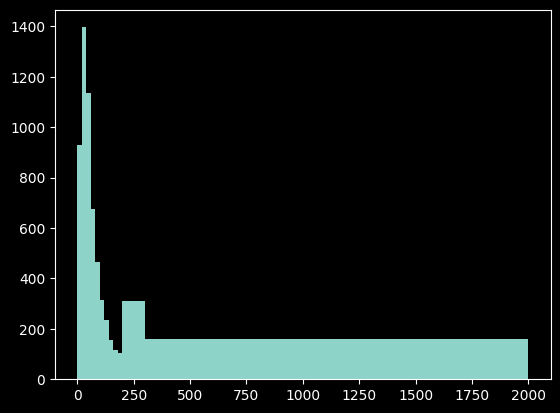

In [18]:
# Some investigations
lengths = [len(sentence) for sentence in x_train]
lengths.sort()
print("Max size:", max(lengths))
print("Min size:", min(lengths))
print("Top 10 sizes:",lengths[-20:])
counts,bins,_ = plt.hist(lengths,bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 2000])
for i in range(len(counts)-1):
  print('From ',bins[i],'to',bins[i+1],':',counts[i])

plt.show()

# Most reviews are less than 100 words (4614), and 918 reviews are less than 200 but greater than 100
# Lets take max sequence length as 125 (using weighted mean and neglecting reviews above 300 words)
# or 175 if we took all review sizes into consideration

In [19]:
# Get the vocab
vocab = set()
for sentence in x_train:
  for word in sentence:
    vocab.add(word)

vocab.add('') # for dummy words, to avoid adding a word that has a meaning
print("Vocab size:", len(vocab))

# Make a mapping betwween words and their IDs
word2id = {word:id for  id, word in enumerate(vocab)}
id2word = {id:word for  id, word in enumerate(vocab)}

Vocab size: 43101


In [20]:
def encode_sentence(old_sentence):
  encoded_sentence = []
  dummy = word2id['']
  for word in old_sentence:
    try:
      encoded_sentence.append(word2id[word])
    except KeyError:
      encoded_sentence.append(dummy) # the none char

  return encoded_sentence

In [21]:
# Encoding train sentences
x_train_encoded = []
for sentence in x_train:
  x_train_encoded.append(encode_sentence(sentence))

# Encoding test sentences
x_test_encoded = []
for sentence in x_test:
  x_test_encoded.append(encode_sentence(sentence))

print("Len train:", len(x_train_encoded))
print("Len test:", len(x_test_encoded))

Len train: 6000
Len test: 2000


In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQ_LEN = 125
dummy = word2id['']
# Padding train sentences
x_train_padded = pad_sequences(x_train_encoded, maxlen=MAX_SEQ_LEN, dtype='int', padding='post', truncating='post', value=dummy)
print("Train shape: ",x_train_padded.shape)

# Padding test sentences
x_test_padded = pad_sequences(x_test_encoded, maxlen=MAX_SEQ_LEN, dtype='int', padding='post', truncating='post', value=dummy)
print("Test shape: ", x_test_padded.shape)

Train shape:  (6000, 125)
Test shape:  (2000, 125)


In [26]:
# Changing labels type and shape for training
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))
y_train.shape

y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))
y_test.shape

(2000, 1)

In [28]:
# Loading the Word2Vec Model
# glove-twitter-200 model was trained on 2B tweets
# with a 1.2M vocab size
import gensim
import gensim.downloader as api
w2v = api.load('glove-twitter-200')
w2v.most_similar("mahmoud")

[==================================================] 100.0% 758.5/758.5MB downloaded


[('mohamed', 0.71284019947052),
 ('mostafa', 0.6895012259483337),
 ('ahmed', 0.6817302703857422),
 ('mohey', 0.6513986587524414),
 ('ahmadinejad', 0.6093316078186035),
 ('mohammed', 0.5743428468704224),
 ('youssef', 0.5647962689399719),
 ('morsi', 0.554459810256958),
 ('hassan', 0.5542215704917908),
 ('fouad', 0.5403571724891663)]

In [29]:
# Create an embedding matrix for the embedding layer
num_words = len(vocab)
embed_size, = w2v['mahmoud'].shape
embedding_matrix = np.zeros(shape=(num_words, embed_size))

for word, id in word2id.items():
  try:
    embedding_matrix[id] = w2v[word]
  except KeyError:
    embedding_matrix[id] = np.zeros(embed_size)

embedding_matrix.shape

(43101, 200)

In [33]:
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, TimeDistributed
from tensorflow.keras.models import Sequential

tf.keras.backend.clear_session() # Makes sure old model was deleted if exists

# create model
lstm_model = Sequential(name='Rating')

lstm_model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))

lstm_model.add(Embedding(input_dim = len(vocab),            # Vocabulary Size (number of unique words for training)
                        output_dim = embed_size,            # Length of the vector for each word (embedding dimension)
                        weights = [embedding_matrix],       # Send the needed glove-twitter-200 Weights
                        trainable = False))

lstm_model.add(LSTM(units = 30,
                    return_sequences=True,
                    # dropout=0.5,
                    # recurrent_dropout=0.5
                    )
              )
lstm_model.add(LSTM(units = 30,
                    # return_sequences=True,
                    # dropout=0.5,
                    # recurrent_dropout=0.5
                    )
              )
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()

Model: "Rating"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 125, 200)       │     8,620,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 30)        │        27,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,655,271 (33.02 MB)

 Trainable params: 35,071 (137.00 KB)

 Non-trainable params: 8,620,200 (32.88 MB)

In [34]:
train_data, train_labels = shuffle(x_train_padded, y_train, random_state=42)

In [44]:
import pickle
lstm_model.save("./sentiment_app/data/model/lstm_w_770.h5",save_format="h5")

from tensorflow.keras.preprocessing.text import Tokenizer

# Fit the tokenizer on your training data if not already done
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(sentence) for sentence in x_train])

with open("./sentiment_app/data/model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [36]:
lstm_model.fit(train_data,
               train_labels,
               validation_split=0.20,
               batch_size = 50,
               epochs = 50)

Epoch 1/50


2025-05-05 12:52:06.769721: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4999 - loss: 0.6929 - val_accuracy: 0.5250 - val_loss: 0.6940
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5146 - loss: 0.6919 - val_accuracy: 0.5175 - val_loss: 0.6932
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5108 - loss: 0.6905 - val_accuracy: 0.5242 - val_loss: 0.6917
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5311 - loss: 0.6893 - val_accuracy: 0.5283 - val_loss: 0.6899
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5265 - loss: 0.6874 - val_accuracy: 0.5358 - val_loss: 0.6862
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5424 - loss: 0.6828 - val_accuracy: 0.5350 - val_loss: 0.6796
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5599 - loss: 0.6729 - val_accuracy: 0.5983 - val_loss: 0.6648
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6639 - loss: 0.6452 - val_accuracy: 0.6558 - val_loss: 0.

In [37]:
l, a = lstm_model.evaluate(x_test_padded, y_test)
print("Test accuracy:", round(a*100,2),"%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7409 - loss: 0.6175
Test accuracy: 74.9 %


In [38]:
# Custom function to predict sentences
def lstm_predict(sentence:str):
  sentence = clean_sentence(sentence)
  # Encode sentence
  ready_sentence = encode_sentence(sentence)
  # Padding sentence
  ready_sentence = pad_sequences(sequences = [ready_sentence],
                                 maxlen=MAX_SEQ_LEN,
                                 dtype='int32',
                                 padding='post',
                                 truncating='post',
                                 value = dummy)

  # Predict
  prediction = round(lstm_model.predict(ready_sentence)[0][0])
  if prediction==0:
    print("Negative Review")
  elif prediction==1:
    print("Positive Review")
  else:
    print('Error')


In [39]:
# Straight forward positive
lstm_predict("I really recommend this book")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Positive Review


In [58]:
# Tricky positive
lstm_predict("The dvd included a big poster of my favorite hero. I just can't wait for the second episode")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Positive Review


In [59]:
# Straight forward negative
lstm_predict("I don't know what the hell did i just read, the book is full nonsense")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Negative Review
